In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
   sys.path.append(project_root)

from source.utils.minio_helper import read_df_from_minio

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) # Agar list panjang tidak terpotong

BUCKET_NAME = "mlbb-lakehouse"

In [6]:
df_train = read_df_from_minio(BUCKET_NAME, "gold/features_draft_model.parquet", file_format='parquet')
print(f"--Data Loaded: {df_train.shape}")

--Data Loaded: (414, 18)


In [12]:
df_train.head()

,match_id,Label_Winner,T1_Avg_WinRate,T1_Total_Counter,T1_Avg_Tier,T1_Hero_1,T1_Hero_2,T1_Hero_3,T1_Hero_4,T1_Hero_5,T2_Avg_WinRate,T2_Total_Counter,T2_Avg_Tier,T2_Hero_1,T2_Hero_2,T2_Hero_3,T2_Hero_4,T2_Hero_5,Diff_Counter,Diff_WinRate,Diff_Tier
0,1,1,50.770,0.68,1.6,cici,joy,pharsa,claude,hylos,48.154,0.00,2.4,esmeralda,lancelot,helcurt,harith,gatotkaca,0.68,2.616,-0.8
1,2,1,47.554,0.84,3.0,cici,lancelot,pharsa,granger,gatotkaca,49.292,0.00,1.0,esmeralda,joy,kagura,kalea,beatrix,0.84,-1.738,2.0
2,3,0,48.240,2.61,1.6,uranus,fanny,pharsa,moskov,gatotkaca,47.046,1.01,2.2,cici,baxia,valentina,granger,franco,1.60,1.194,-0.6
3,4,0,48.604,0.04,1.2,paquito,baxia,pharsa,granger,badang,50.674,0.13,2.0,cici,fredrinn,lylia,harith,gatotkaca,-0.09,-2.070,-0.8
4,5,0,49.642,1.29,1.2,phoveus,fanny,kimmy,claude,baxia,50.176,0.53,2.6,gloo,hayabusa,pharsa,moskov,chou,0.76,-0.534,-1.4


In [7]:
# --- DIAGNOSA 1: EFEKTIVITAS FITUR (CORRELATION) ---
# XGBoost butuh sinyal yang kuat. Mari kita cek korelasi mentah.
# Kita berharap:
# - T1_Total_Counter berkorelasi POSITIF dengan Label_Winner
# - T2_Total_Counter berkorelasi NEGATIF dengan Label_Winner

In [13]:
numeric_cols = [
   'Label_Winner', 
   'T1_Avg_WinRate', 'T1_Total_Counter', 'T1_Avg_Tier',
   'T2_Avg_WinRate', 'T2_Total_Counter', 'T2_Avg_Tier'
]

print("\n--KORELASI FITUR DENGAN LABEL PEMENANG:")
corr = df_train[numeric_cols].corr()['Label_Winner'].sort_values(ascending=False)
print(corr)


--KORELASI FITUR DENGAN LABEL PEMENANG:
Label_Winner        1.000000
T1_Avg_Tier         0.136755
T2_Avg_WinRate      0.098292
T2_Avg_Tier         0.051542
T1_Total_Counter    0.018978
T2_Total_Counter   -0.027501
T1_Avg_WinRate     -0.056254
Name: Label_Winner, dtype: float64


In [8]:
numeric_cols = [
   'Label_Winner', 
   'T1_Avg_WinRate', 'T1_Total_Counter', 'T1_Avg_Tier',
   'T2_Avg_WinRate', 'T2_Total_Counter', 'T2_Avg_Tier'
]

print("\n--KORELASI FITUR DENGAN LABEL PEMENANG:")
corr = df_train[numeric_cols].corr()['Label_Winner'].sort_values(ascending=False)
print(corr)


--KORELASI FITUR DENGAN LABEL PEMENANG:
Label_Winner        1.000000
T1_Avg_Tier         0.136755
T2_Avg_WinRate      0.098292
T2_Avg_Tier         0.051542
T1_Total_Counter    0.018978
T2_Total_Counter   -0.027501
T1_Avg_WinRate     -0.056254
Name: Label_Winner, dtype: float64


In [9]:
df_train['Diff_Counter'] = df_train['T1_Total_Counter'] - df_train['T2_Total_Counter']
df_train['Diff_WinRate'] = df_train['T1_Avg_WinRate'] - df_train['T2_Avg_WinRate']
df_train['Diff_Tier'] = df_train['T1_Avg_Tier'] - df_train['T2_Avg_Tier']

print("\n--KORELASI FITUR SELISIH (DIFF) DENGAN LABEL:")
diff_cols = ['Label_Winner', 'Diff_Counter', 'Diff_WinRate', 'Diff_Tier']
print(df_train[diff_cols].corr()['Label_Winner'].sort_values(ascending=False))


--KORELASI FITUR SELISIH (DIFF) DENGAN LABEL:
Label_Winner    1.000000
Diff_Tier       0.062409
Diff_Counter    0.031739
Diff_WinRate   -0.098948
Name: Label_Winner, dtype: float64


In [10]:
zero_matches = df_train[(df_train['T1_Total_Counter'] == 0) & (df_train['T2_Total_Counter'] == 0)]
print(f"\n--Match dengan Counter Score 0 di kedua tim: {len(zero_matches)} dari {len(df_train)}")


--Match dengan Counter Score 0 di kedua tim: 12 dari 414


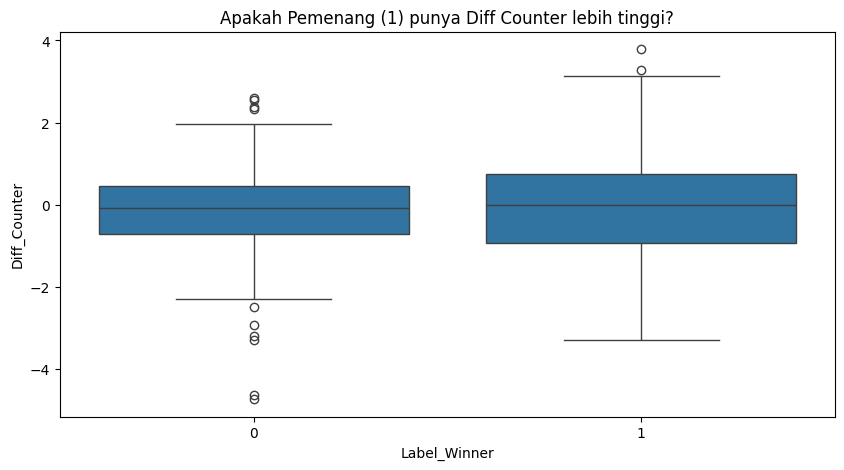

In [11]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Label_Winner', y='Diff_Counter', data=df_train)
plt.title("Apakah Pemenang (1) punya Diff Counter lebih tinggi?")
plt.show()